In [8]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def load_data(generation_path: str, consumption_path: str) -> pd.DataFrame:
    df_gen = pd.read_csv(generation_path)
    df_cons = pd.read_csv(consumption_path)
    
    df_gen['Tarih'] = pd.to_datetime(df_gen['Tarih'] + ' ' + df_gen['hour'], format='%d.%m.%Y %H:%M')
    df_cons['Tarih'] = pd.to_datetime(df_cons['Tarih'] + ' ' + df_cons['hour'], format='%d.%m.%Y %H:%M')
    
    df = pd.merge(df_gen, df_cons[['Tarih', 'consumption']], on='Tarih', how='inner')
    return df

def create_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['hour'] = df['Tarih'].dt.hour
    df['day'] = df['Tarih'].dt.day
    df['month'] = df['Tarih'].dt.month
    df['day_of_week'] = df['Tarih'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    
    df['lag_24'] = df['total'].shift(24)
    df['lag_168'] = df['total'].shift(168)
    df['lag_336'] = df['total'].shift(336) 
    
    df['rolling_mean_24h'] = df['total'].rolling(window=24).mean()
    df['rolling_mean_168h'] = df['total'].rolling(window=168).mean()
    df['rolling_std_24h'] = df['total'].rolling(window=24).std()
    
    df['trend_24h'] = df['total'].diff(24)
    df['trend_168h'] = df['total'].diff(168)
    
    df = df.fillna(method='bfill')
    df = df.fillna(method='ffill')  
    
    return df

def prepare_data_for_autoformer(df: pd.DataFrame, feature_columns: list, seq_len: int = 24, pred_len: int = 12):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X = df[feature_columns].values
    y = df['consumption'].values.reshape(-1, 1)
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    X_sequences = []
    y_sequences = []
    
    for i in range(len(df) - seq_len - pred_len + 1):
        X_sequences.append(X_scaled[i:(i + seq_len)])
        y_sequences.append(y_scaled[(i + seq_len):(i + seq_len + pred_len)])
    
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)
    
    train_size = int(0.8 * len(X_sequences))
    
    X_train = X_sequences[:train_size]
    y_train = y_sequences[:train_size]
    X_test = X_sequences[train_size:]
    y_test = y_sequences[train_size:]
    
    return (X_train, y_train, X_test, y_test), (scaler_X, scaler_y)

def calculate_metrics(actuals, predictions):
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    r2 = r2_score(actuals, predictions)
    
    print("\n=== Model Performans Metrikleri ===")
    print(f"MSE     : {mse:.2f}")
    print(f"RMSE    : {rmse:.2f}")
    print(f"MAE     : {mae:.2f}")
    print(f"MAPE    : {mape:.2f}%")
    print(f"R²      : {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

C:\Users\musta\AppData\Local\Temp\ipykernel_6176\11035406.py:53: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')
C:\Users\musta\AppData\Local\Temp\ipykernel_6176\11035406.py:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Başta kalan NaN'lar için


Mevcut sütunlar: ['Tarih', 'hour', 'total', 'consumption', 'day', 'month', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'lag_24', 'lag_168', 'lag_336', 'rolling_mean_24h', 'rolling_mean_168h', 'rolling_std_24h', 'trend_24h', 'trend_168h']
Epoch [1/25], Train Loss: 0.0052, Val Loss: 0.0079
Epoch [2/25], Train Loss: 0.0021, Val Loss: 0.0028
Epoch [3/25], Train Loss: 0.0018, Val Loss: 0.0026
Epoch [4/25], Train Loss: 0.0016, Val Loss: 0.0029
Epoch [5/25], Train Loss: 0.0016, Val Loss: 0.0029
Epoch [6/25], Train Loss: 0.0015, Val Loss: 0.0026
Epoch [7/25], Train Loss: 0.0014, Val Loss: 0.0042
Epoch [8/25], Train Loss: 0.0014, Val Loss: 0.0031
Epoch [9/25], Train Loss: 0.0013, Val Loss: 0.0042
Epoch [10/25], Train Loss: 0.0010, Val Loss: 0.0022
Epoch [11/25], Train Loss: 0.0010, Val Loss: 0.0021
Epoch [12/25], Train Loss: 0.0009, Val Loss: 0.0021
Epoch [13/25], Train Loss: 0.0009, Val Loss: 0.0023
Epoch [14/25], Train Loss: 0.0009, Val Loss: 0.0019
Epoch [1

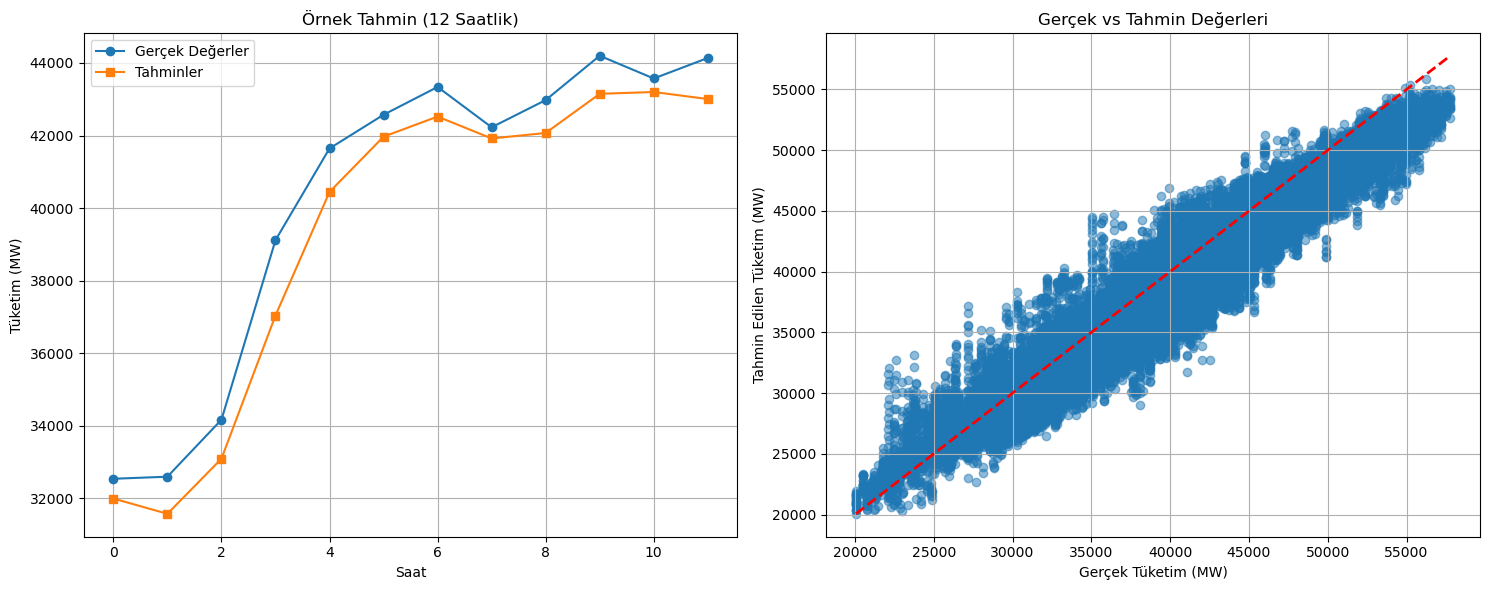

In [10]:
import torch
import torch.nn as nn
import copy

class AutoformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        
        self.attention = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)
        
        ff_output = self.ff(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)
        
        return x

class Autoformer(nn.Module):
    def __init__(self, input_size, d_model=64, n_heads=8, n_layers=3, dropout=0.1, pred_len=12):
        super().__init__()
        
        self.pred_len = pred_len  
        
        self.input_projection = nn.Linear(input_size, d_model)
        
        self.layers = nn.ModuleList([
            AutoformerBlock(d_model, n_heads, dropout=dropout)
            for _ in range(n_layers)
        ])
        
        self.output_projection = nn.Linear(d_model, pred_len)  
        self.decomp = nn.Linear(d_model, d_model)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = self.input_projection(x)
        
        for layer in self.layers:
            x = layer(x)
        
        x = x[:, -1, :]  
        
        x = self.decomp(x)
        
        x = self.output_projection(x)  
        
        return x.unsqueeze(-1)  

def create_model(input_size, pred_len=12):
    model = Autoformer(
        input_size=input_size,
        d_model=128,      
        n_heads=16,       
        n_layers=4,      
        dropout=0.2,     
        pred_len=pred_len
    )
    return model

def train_model(model, train_loader, test_loader, num_epochs=25):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    best_val_loss = float('inf')
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x) 
            loss = criterion(output, batch_y)  
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                output = model(batch_x)
                val_loss += criterion(output, batch_y).item()
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}')
    
    return best_model

if __name__ == "__main__":
    df = load_data('csv_files/realtime_generation_data.csv', 
                   'csv_files/realtime_consumption_data.csv')
    
    df = create_features(df)
    
    print("Mevcut sütunlar:", df.columns.tolist())
    missing_features = [col for col in feature_columns if col not in df.columns]
    if missing_features:
        print("Eksik sütunlar:", missing_features)
        raise ValueError(f"Bu sütunlar eksik: {missing_features}")
    
    # Veriyi hazırla
    (X_train, y_train, X_test, y_test), (scaler_X, scaler_y) = prepare_data_for_autoformer(df, feature_columns)
    
    # Model oluştur
    model = create_model(input_size=len(feature_columns))
    
    # Veriyi PyTorch tensor'larına çevir
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)
    
    # DataLoader'ları oluştur
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
    
    # Modeli eğit
    best_model = train_model(model, train_loader, test_loader)
    
   # Tahminleri yap
# Tahminleri yap
best_model.eval()
predictions_list = []
with torch.no_grad():
    for i in range(0, len(X_test), 32):  # 32'lik batch'ler halinde işle
        batch_x = X_test[i:i+32]
        batch_pred = best_model(batch_x)
        predictions_list.append(batch_pred)

# Tahminleri birleştir
predictions = torch.cat(predictions_list, dim=0)

# Boyutları düzenle (3D -> 2D)
predictions = predictions.squeeze(-1).numpy()  # Son boyutu sıkıştır
actuals = y_test.squeeze(-1).numpy()

# Ölçeklendirmeyi geri al
predictions = scaler_y.inverse_transform(predictions)
actuals = scaler_y.inverse_transform(actuals)

# Metrikleri hesapla
metrics = calculate_metrics(actuals.reshape(-1), predictions.reshape(-1))

# Sonuçları görselleştir
def visualize_results(predictions, actuals):
    plt.figure(figsize=(15, 6))
    
    # Örnek tahmin serisi
    plt.subplot(121)
    plt.plot(actuals[0], label='Gerçek Değerler', marker='o')
    plt.plot(predictions[0], label='Tahminler', marker='s')
    plt.title('Örnek Tahmin (12 Saatlik)')
    plt.xlabel('Saat')
    plt.ylabel('Tüketim (MW)')
    plt.legend()
    plt.grid(True)
    
    # Scatter plot
    plt.subplot(122)
    plt.scatter(actuals.reshape(-1), predictions.reshape(-1), alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
    plt.title('Gerçek vs Tahmin Değerleri')
    plt.xlabel('Gerçek Tüketim (MW)')
    plt.ylabel('Tahmin Edilen Tüketim (MW)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

visualize_results(predictions, actuals)

Mevcut sütunlar: ['Tarih', 'hour', 'total', 'consumption', 'day', 'month', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'lag_24', 'lag_168', 'lag_336', 'rolling_mean_24h', 'rolling_mean_168h', 'rolling_std_24h', 'trend_24h', 'trend_168h']
Epoch [1/25], Train Loss: 0.0047, Val Loss: 0.0038
Epoch [2/25], Train Loss: 0.0018, Val Loss: 0.0030
Epoch [3/25], Train Loss: 0.0015, Val Loss: 0.0029
Epoch [4/25], Train Loss: 0.0013, Val Loss: 0.0024
Epoch [5/25], Train Loss: 0.0012, Val Loss: 0.0038
Epoch [6/25], Train Loss: 0.0011, Val Loss: 0.0018
Epoch [7/25], Train Loss: 0.0011, Val Loss: 0.0028
Epoch [8/25], Train Loss: 0.0010, Val Loss: 0.0042
Epoch [9/25], Train Loss: 0.0010, Val Loss: 0.0045
Epoch [10/25], Train Loss: 0.0010, Val Loss: 0.0029
Epoch [11/25], Train Loss: 0.0009, Val Loss: 0.0033
Epoch [12/25], Train Loss: 0.0009, Val Loss: 0.0021
Epoch [13/25], Train Loss: 0.0006, Val Loss: 0.0022
Epoch [14/25], Train Loss: 0.0006, Val Loss: 0.0019
Epoch [1

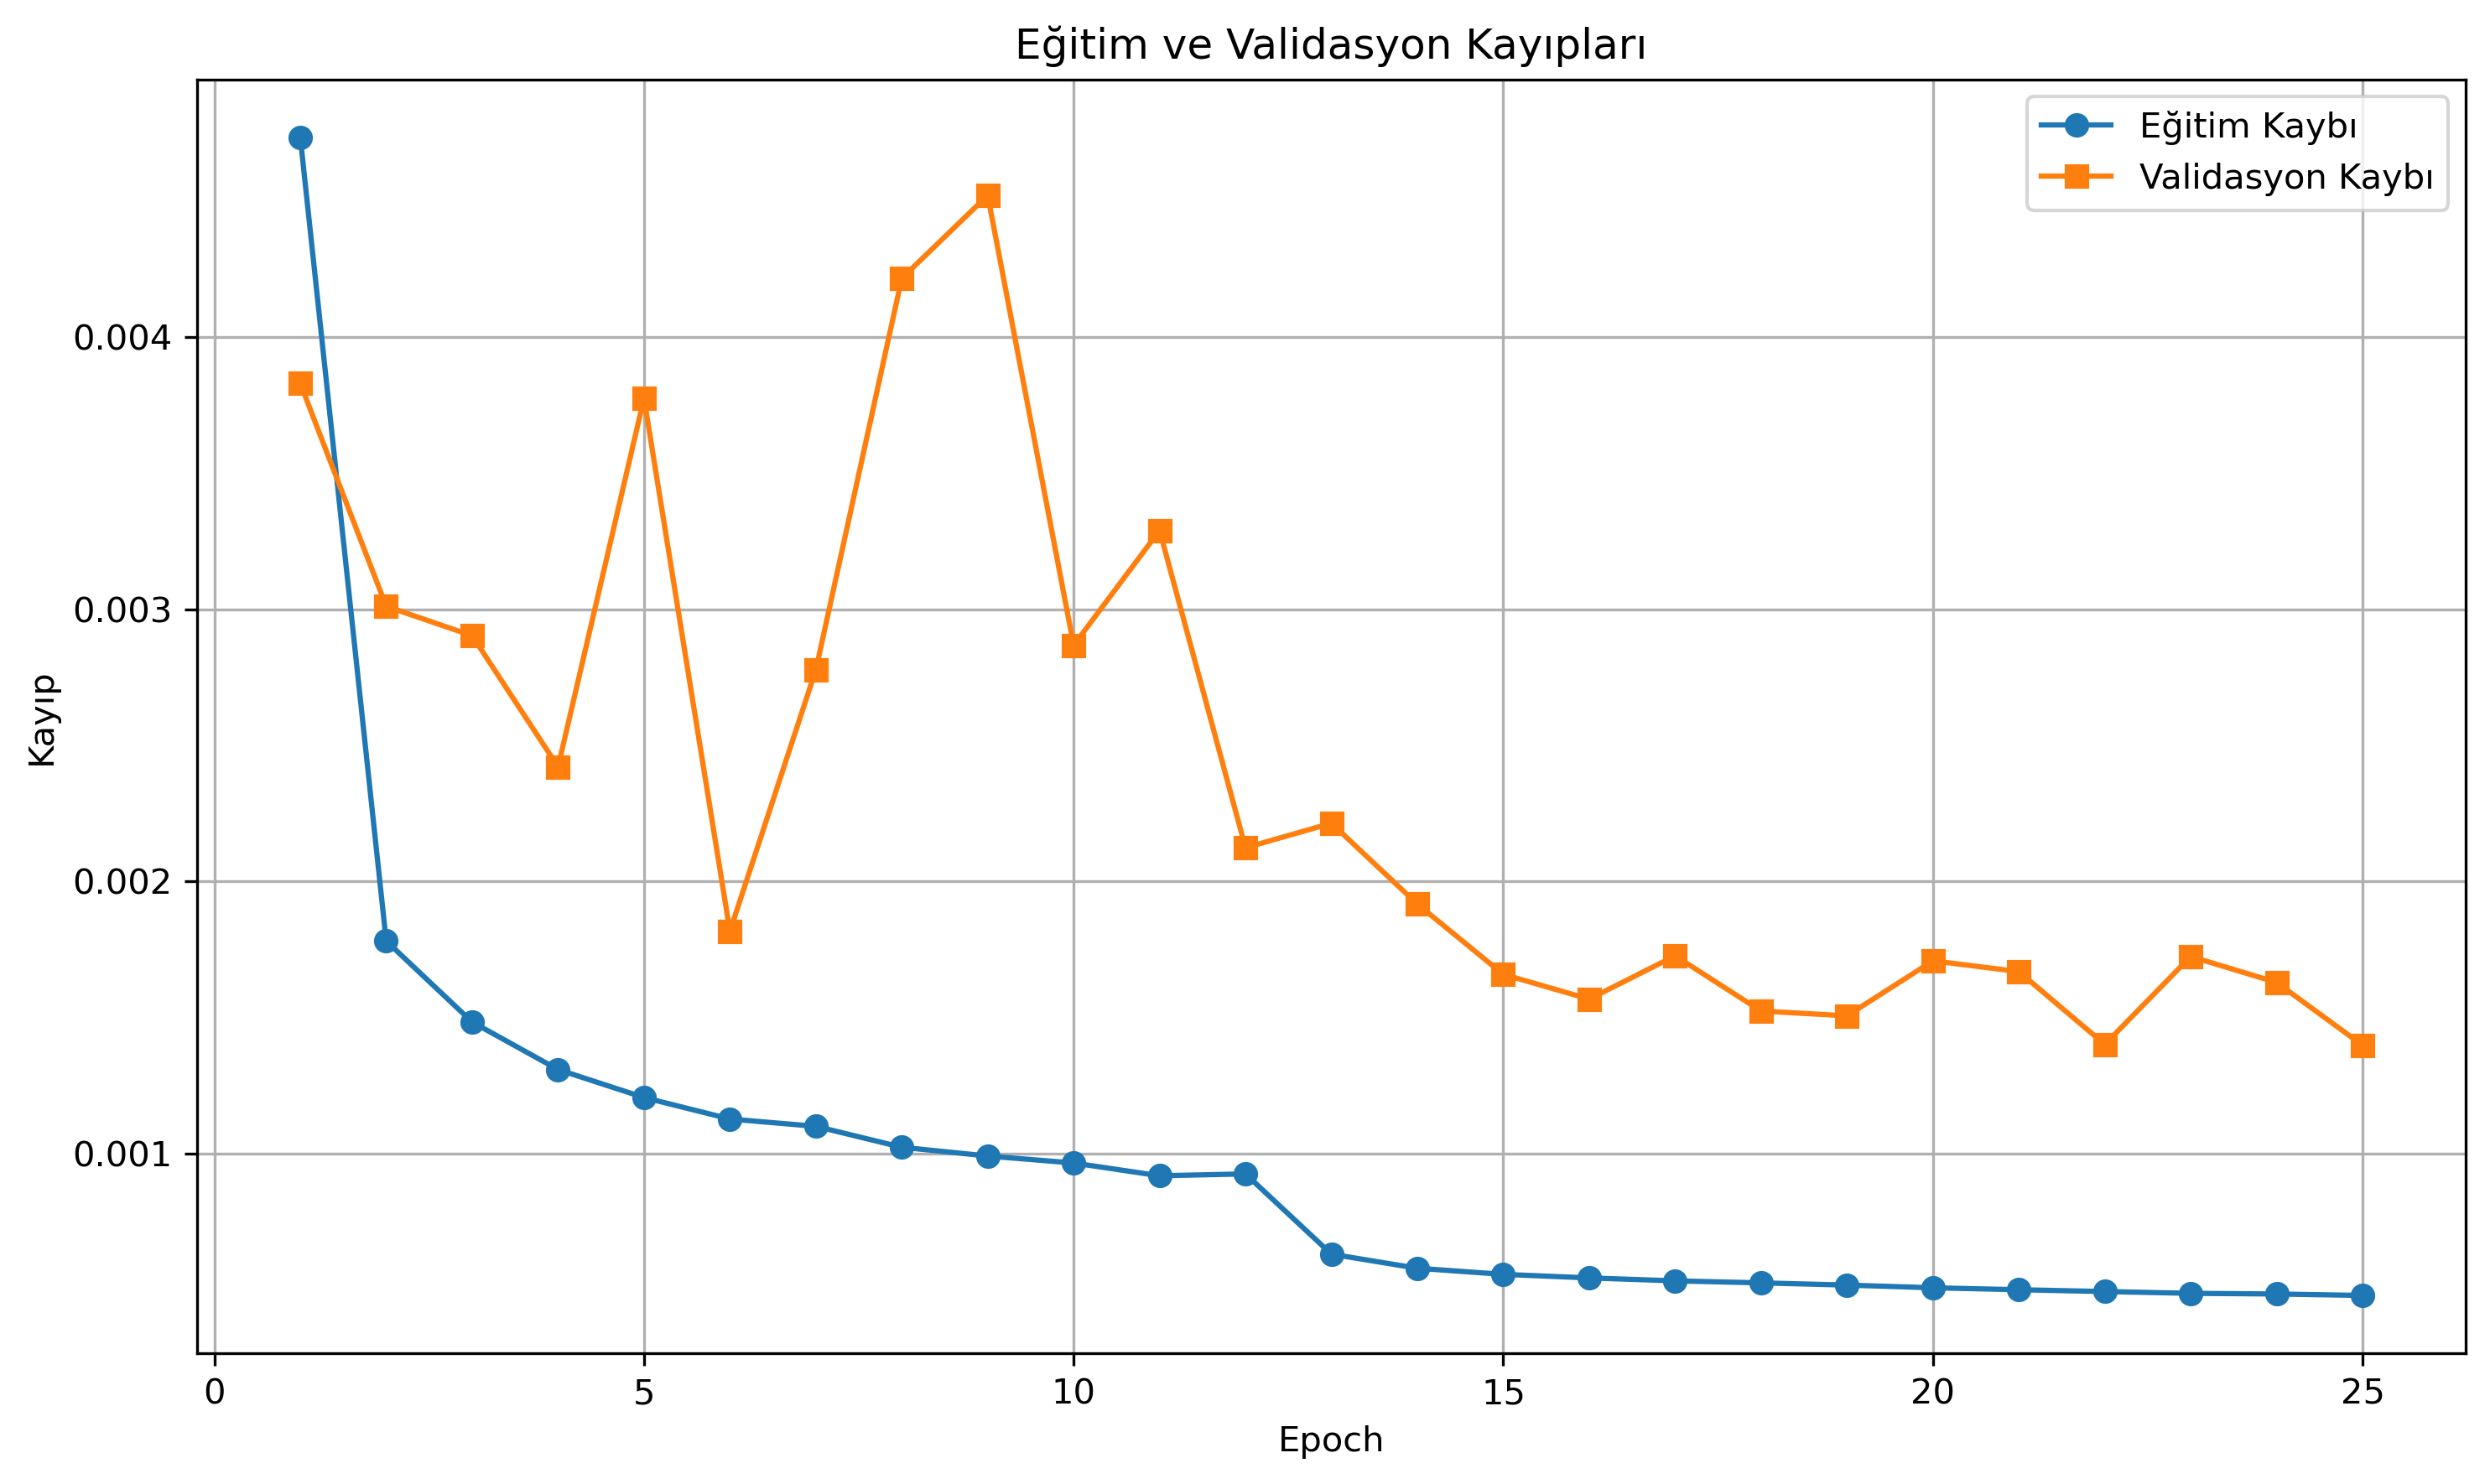


=== Model Performans Metrikleri ===
MSE     : 2517950.75
RMSE    : 1586.81
MAE     : 1188.23
MAPE    : 3.04%
R²      : 0.9373


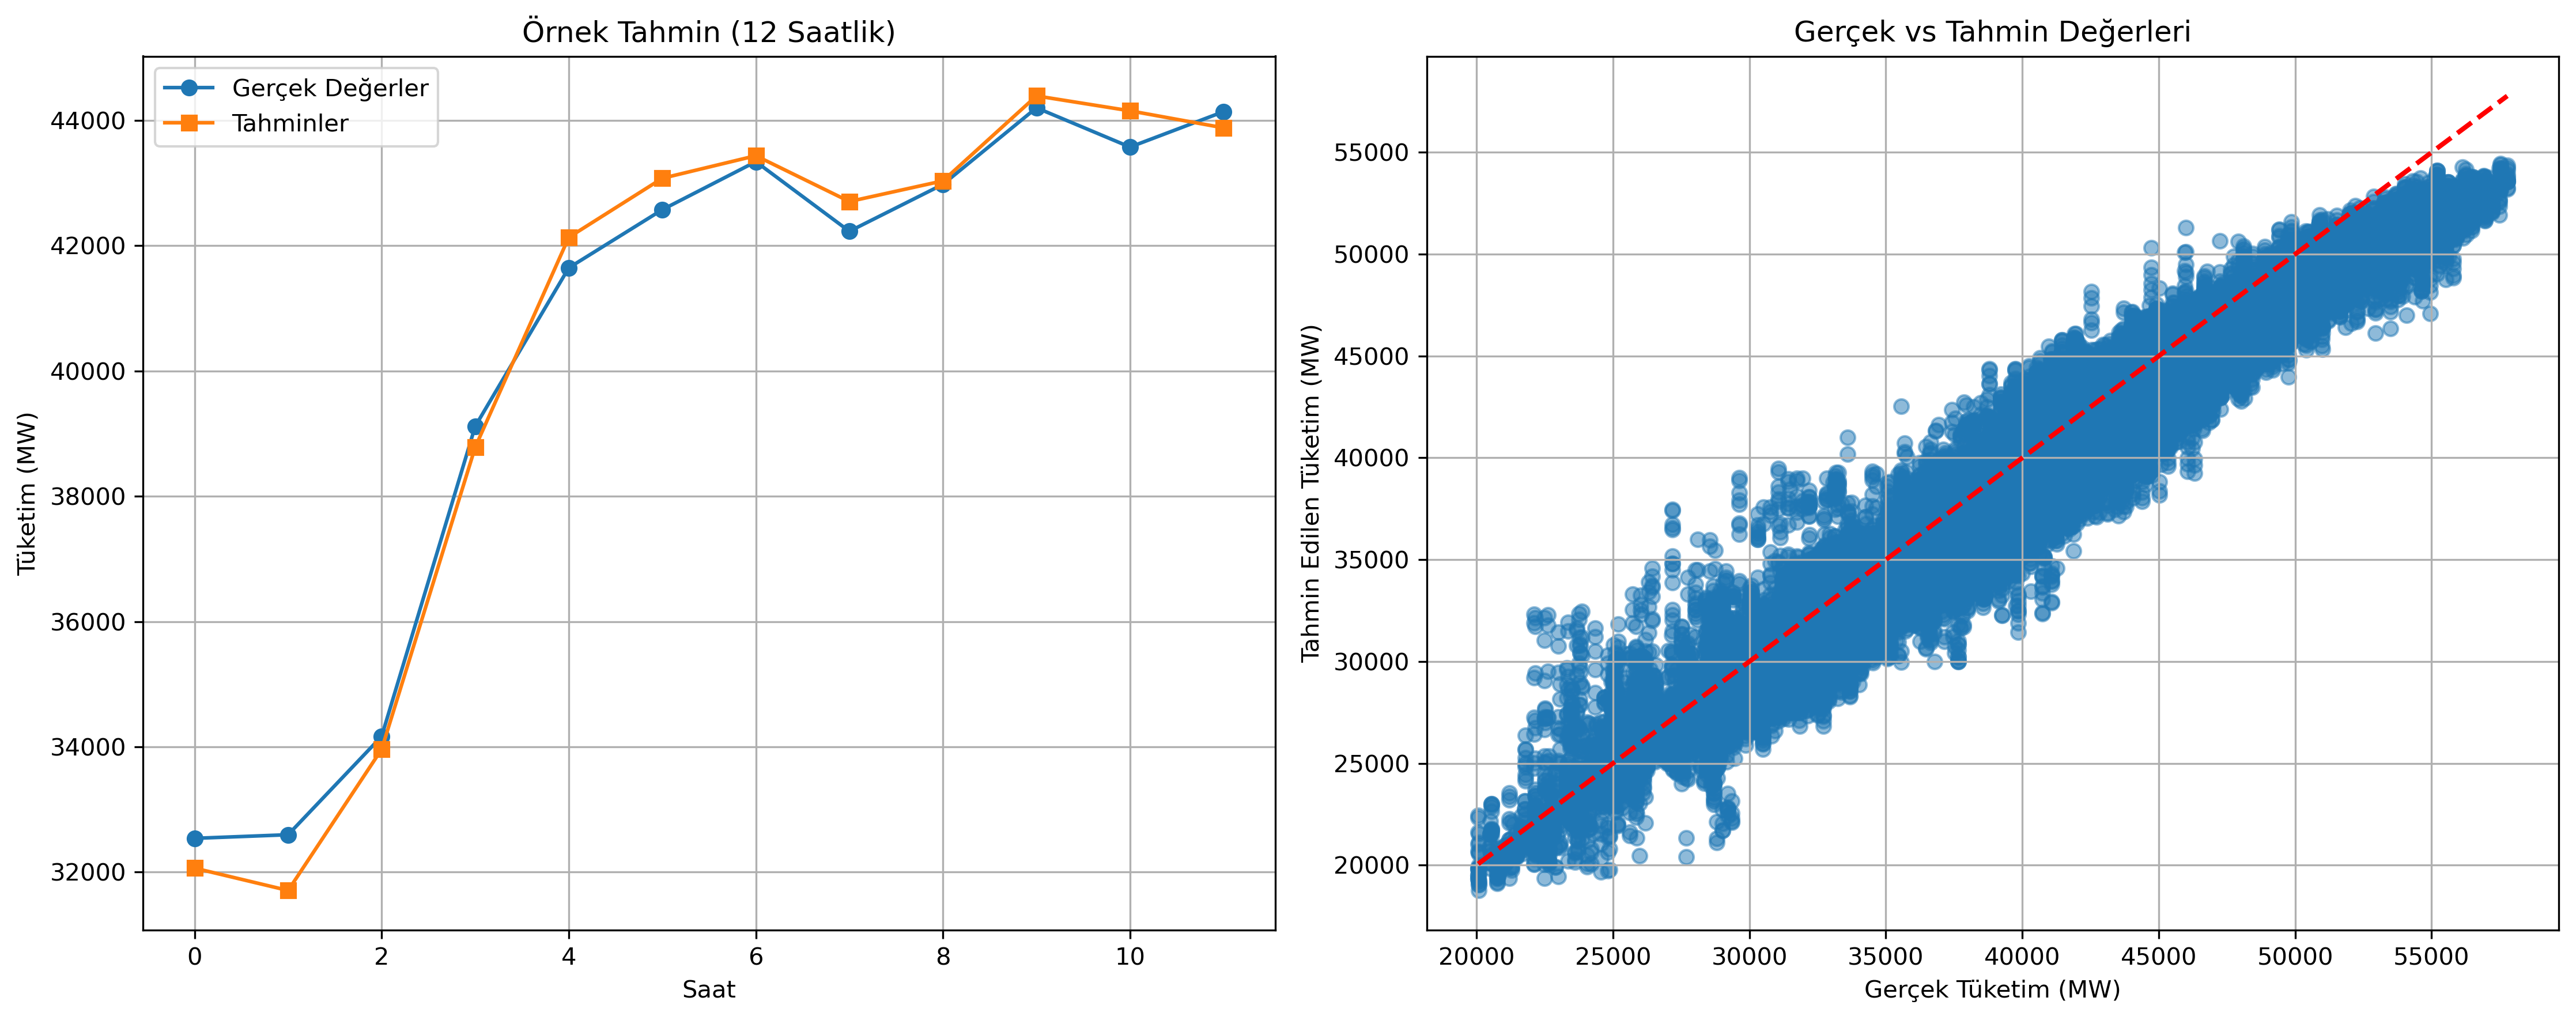


Model Süre Metrikleri:
+------------------------------------+---------+
| Metrik                             |   Değer |
+====================================+=========+
| Eğitim Süresi (saniye)             | 1644.97 |
+------------------------------------+---------+
| Çıkarım Süresi (saniye)            |    3.85 |
+------------------------------------+---------+
| Ortalama Çıkarım Süresi (ms/örnek) |    0.37 |
+------------------------------------+---------+


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import copy
import time
from tabulate import tabulate

def load_data(generation_path: str, consumption_path: str) -> pd.DataFrame:
    df_gen = pd.read_csv(generation_path)
    df_cons = pd.read_csv(consumption_path)
    
    df_gen['Tarih'] = pd.to_datetime(df_gen['Tarih'] + ' ' + df_gen['hour'], format='%d.%m.%Y %H:%M')
    df_cons['Tarih'] = pd.to_datetime(df_cons['Tarih'] + ' ' + df_cons['hour'], format='%d.%m.%Y %H:%M')
    
    df = pd.merge(df_gen, df_cons[['Tarih', 'consumption']], on='Tarih', how='inner')
    return df

def create_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['hour'] = df['Tarih'].dt.hour
    df['day'] = df['Tarih'].dt.day
    df['month'] = df['Tarih'].dt.month
    df['day_of_week'] = df['Tarih'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    
    df['lag_24'] = df['total'].shift(24)
    df['lag_168'] = df['total'].shift(168)
    df['lag_336'] = df['total'].shift(336)
    
    df['rolling_mean_24h'] = df['total'].rolling(window=24).mean()
    df['rolling_mean_168h'] = df['total'].rolling(window=168).mean()
    df['rolling_std_24h'] = df['total'].rolling(window=24).std()
    
    df['trend_24h'] = df['total'].diff(24)
    df['trend_168h'] = df['total'].diff(168)
    
    df = df.bfill()
    df = df.ffill()
    
    return df

def prepare_data_for_autoformer(df: pd.DataFrame, feature_columns: list, seq_len: int = 24, pred_len: int = 12):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X = df[feature_columns].values
    y = df['consumption'].values.reshape(-1, 1)
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    X_sequences = []
    y_sequences = []
    
    for i in range(len(df) - seq_len - pred_len + 1):
        X_sequences.append(X_scaled[i:(i + seq_len)])
        y_sequences.append(y_scaled[(i + seq_len):(i + seq_len + pred_len)])
    
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)
    
    train_size = int(0.8 * len(X_sequences))
    
    X_train = X_sequences[:train_size]
    y_train = y_sequences[:train_size]
    X_test = X_sequences[train_size:]
    y_test = y_sequences[train_size:]
    
    return (X_train, y_train, X_test, y_test), (scaler_X, scaler_y)

class AutoformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        
        self.attention = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)
        
        ff_output = self.ff(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)
        
        return x

class Autoformer(nn.Module):
    def __init__(self, input_size, d_model=64, n_heads=8, n_layers=3, dropout=0.1, pred_len=12):
        super().__init__()
        
        self.pred_len = pred_len
        self.input_projection = nn.Linear(input_size, d_model)
        self.layers = nn.ModuleList([
            AutoformerBlock(d_model, n_heads, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.output_projection = nn.Linear(d_model, pred_len)
        self.decomp = nn.Linear(d_model, d_model)
        
    def forward(self, x):
        x = self.input_projection(x)
        for layer in self.layers:
            x = layer(x)
        x = x[:, -1, :]
        x = self.decomp(x)
        x = self.output_projection(x)
        return x.unsqueeze(-1)

def create_model(input_size, pred_len=12):
    return Autoformer(
        input_size=input_size,
        d_model=128,
        n_heads=16,
        n_layers=4,
        dropout=0.2,
        pred_len=pred_len
    )

def train_model(model, train_loader, test_loader, num_epochs=25):
    training_start_time = time.time()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    best_val_loss = float('inf')
    best_model = None
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss/len(train_loader)
        train_losses.append(avg_train_loss)
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                output = model(batch_x)
                val_loss += criterion(output, batch_y).item()
        
        avg_val_loss = val_loss/len(test_loader)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = copy.deepcopy(model)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    training_time = time.time() - training_start_time
    
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Eğitim Kaybı', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validasyon Kaybı', marker='s')
    plt.title('Eğitim ve Validasyon Kayıpları')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return best_model, training_time

def evaluate_model(model, X_test, batch_size=32):
    inference_start_time = time.time()
    
    model.eval()
    predictions_list = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_x = X_test[i:i+batch_size]
            batch_pred = model(batch_x)
            predictions_list.append(batch_pred)
    
    inference_time = time.time() - inference_start_time
    predictions = torch.cat(predictions_list, dim=0)
    
    return predictions, inference_time

def calculate_metrics(actuals, predictions):
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    r2 = r2_score(actuals, predictions)
    
    print("\n=== Model Performans Metrikleri ===")
    print(f"MSE     : {mse:.2f}")
    print(f"RMSE    : {rmse:.2f}")
    print(f"MAE     : {mae:.2f}")
    print(f"MAPE    : {mape:.2f}%")
    print(f"R²      : {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

def visualize_results(predictions, actuals):
    plt.figure(figsize=(15, 6), dpi=300)
    
    plt.subplot(121)
    plt.plot(actuals[0], label='Gerçek Değerler', marker='o')
    plt.plot(predictions[0], label='Tahminler', marker='s')
    plt.title('Örnek Tahmin (12 Saatlik)')
    plt.xlabel('Saat')
    plt.ylabel('Tüketim (MW)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(122)
    plt.scatter(actuals.reshape(-1), predictions.reshape(-1), alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
    plt.title('Gerçek vs Tahmin Değerleri')
    plt.xlabel('Gerçek Tüketim (MW)')
    plt.ylabel('Tahmin Edilen Tüketim (MW)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('prediction_results.png', dpi=300, bbox_inches='tight')
    plt.show()

feature_columns = [
    'hour', 'day', 'month', 'day_of_week', 'is_weekend',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
    'lag_24', 'lag_168', 'lag_336',
    'rolling_mean_24h', 'rolling_mean_168h', 'rolling_std_24h',
    'trend_24h', 'trend_168h'
]

if __name__ == "__main__":
    df = load_data('csv_files/realtime_generation_data.csv', 
                   'csv_files/realtime_consumption_data.csv')
    
    df = create_features(df)
    
    print("Mevcut sütunlar:", df.columns.tolist())
    missing_features = [col for col in feature_columns if col not in df.columns]
    if missing_features:
        print("Eksik sütunlar:", missing_features)
        raise ValueError(f"Bu sütunlar eksik: {missing_features}")
    
    (X_train, y_train, X_test, y_test), (scaler_X, scaler_y) = prepare_data_for_autoformer(df, feature_columns)
    
    model = create_model(input_size=len(feature_columns))
    
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
    
    best_model, training_time = train_model(model, train_loader, test_loader)
    
    predictions, inference_time = evaluate_model(best_model, X_test)
    
    predictions = predictions.squeeze(-1).numpy()
    actuals = y_test.squeeze(-1).numpy()
    predictions = scaler_y.inverse_transform(predictions)
    actuals = scaler_y.inverse_transform(actuals)
    
    metrics = calculate_metrics(actuals.reshape(-1), predictions.reshape(-1))
    
    visualize_results(predictions, actuals)
    
    timing_data = [
        ["Eğitim Süresi (saniye)", f"{training_time:.2f}"],
        ["Çıkarım Süresi (saniye)", f"{inference_time:.2f}"],
        ["Ortalama Çıkarım Süresi (ms/örnek)", f"{(inference_time * 1000 / len(X_test)):.2f}"]
    ]
    
    table = tabulate(timing_data, headers=["Metrik", "Değer"], tablefmt="grid")
    with open("model_timing_results.txt", "w", encoding="utf-8") as f:
        f.write(table)
    
    print("\nModel Süre Metrikleri:")
    print(table)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def load_data(generation_path: str, consumption_path: str) -> pd.DataFrame:
    df_gen = pd.read_csv(generation_path)
    df_cons = pd.read_csv(consumption_path)
    
    df_gen['Tarih'] = pd.to_datetime(df_gen['Tarih'] + ' ' + df_gen['hour'], format='%d.%m.%Y %H:%M')
    df_cons['Tarih'] = pd.to_datetime(df_cons['Tarih'] + ' ' + df_cons['hour'], format='%d.%m.%Y %H:%M')
    
    df = pd.merge(df_gen, df_cons[['Tarih', 'consumption']], on='Tarih', how='inner')
    return df

def create_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['hour'] = df['Tarih'].dt.hour
    df['day'] = df['Tarih'].dt.day
    df['month'] = df['Tarih'].dt.month
    df['day_of_week'] = df['Tarih'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    
    df['lag_24'] = df['total'].shift(24)
    df['lag_168'] = df['total'].shift(168)
    df['lag_336'] = df['total'].shift(336)
    
    df['rolling_mean_24h'] = df['total'].rolling(window=24).mean()
    df['rolling_mean_168h'] = df['total'].rolling(window=168).mean()
    df['rolling_std_24h'] = df['total'].rolling(window=24).std()
    
    df['trend_24h'] = df['total'].diff(24)
    df['trend_168h'] = df['total'].diff(168)
    
    df = df.bfill().ffill()
    
    return df

def prepare_data_for_autoformer(df: pd.DataFrame, feature_columns: list, seq_len: int = 24, pred_len: int = 12):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X = df[feature_columns].values
    y = df['consumption'].values.reshape(-1, 1)
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    X_sequences = []
    y_sequences = []
    
    for i in range(len(df) - seq_len - pred_len + 1):
        X_sequences.append(X_scaled[i:(i + seq_len)])
        y_sequences.append(y_scaled[(i + seq_len):(i + seq_len + pred_len)])
    
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)
    
    train_size = int(0.8 * len(X_sequences))
    
    X_train = X_sequences[:train_size]
    y_train = y_sequences[:train_size]
    X_test = X_sequences[train_size:]
    y_test = y_sequences[train_size:]
    
    return (X_train, y_train, X_test, y_test), (scaler_X, scaler_y)

In [2]:
import torch
import torch.nn as nn
import copy

class AutoformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)
        ff_output = self.ff(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)
        return x

class Autoformer(nn.Module):
    def __init__(self, input_size, d_model=64, n_heads=8, n_layers=3, dropout=0.1, pred_len=12):
        super().__init__()
        self.pred_len = pred_len
        self.input_projection = nn.Linear(input_size, d_model)
        self.layers = nn.ModuleList([
            AutoformerBlock(d_model, n_heads, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.output_projection = nn.Linear(d_model, pred_len)
        self.decomp = nn.Linear(d_model, d_model)
        
    def forward(self, x):
        x = self.input_projection(x)
        for layer in self.layers:
            x = layer(x)
        x = x[:, -1, :]
        x = self.decomp(x)
        x = self.output_projection(x)
        return x.unsqueeze(-1)

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

def create_model(input_size, pred_len=12):
    return Autoformer(
        input_size=input_size,
        d_model=128,
        n_heads=16,
        n_layers=4,
        dropout=0.2,
        pred_len=pred_len
    )

def train_model(model, train_loader, test_loader, num_epochs=25):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    best_val_loss = float('inf')
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                output = model(batch_x)
                val_loss += criterion(output, batch_y).item()
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}')
    
    return best_model

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(actuals, predictions):
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    r2 = r2_score(actuals, predictions)
    
    metrics = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}
    return metrics

def visualize_results(predictions, actuals):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(121)
    plt.plot(actuals[0], label='Gerçek Değerler', marker='o')
    plt.plot(predictions[0], label='Tahminler', marker='s')
    plt.title('Örnek Tahmin (12 Saatlik)')
    plt.xlabel('Saat')
    plt.ylabel('Tüketim (MW)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(122)
    plt.scatter(actuals.reshape(-1), predictions.reshape(-1), alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
    plt.title('Gerçek vs Tahmin Değerleri')
    plt.xlabel('Gerçek Tüketim (MW)')
    plt.ylabel('Tahmin Edilen Tüketim (MW)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [6]:
feature_columns = [
    'hour', 'day', 'month', 'day_of_week', 'is_weekend',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
    'lag_24', 'lag_168', 'lag_336',
    'rolling_mean_24h', 'rolling_mean_168h', 'rolling_std_24h',
    'trend_24h', 'trend_168h'
]

Epoch [1/25], Train Loss: 0.0047, Val Loss: 0.0038
Epoch [2/25], Train Loss: 0.0018, Val Loss: 0.0033
Epoch [3/25], Train Loss: 0.0015, Val Loss: 0.0047
Epoch [4/25], Train Loss: 0.0013, Val Loss: 0.0041
Epoch [5/25], Train Loss: 0.0012, Val Loss: 0.0028
Epoch [6/25], Train Loss: 0.0012, Val Loss: 0.0024
Epoch [7/25], Train Loss: 0.0011, Val Loss: 0.0033
Epoch [8/25], Train Loss: 0.0010, Val Loss: 0.0022
Epoch [9/25], Train Loss: 0.0010, Val Loss: 0.0024
Epoch [10/25], Train Loss: 0.0010, Val Loss: 0.0024
Epoch [11/25], Train Loss: 0.0009, Val Loss: 0.0034
Epoch [12/25], Train Loss: 0.0009, Val Loss: 0.0021
Epoch [13/25], Train Loss: 0.0009, Val Loss: 0.0028
Epoch [14/25], Train Loss: 0.0009, Val Loss: 0.0024
Epoch [15/25], Train Loss: 0.0009, Val Loss: 0.0019
Epoch [16/25], Train Loss: 0.0008, Val Loss: 0.0020
Epoch [17/25], Train Loss: 0.0008, Val Loss: 0.0022
Epoch [18/25], Train Loss: 0.0008, Val Loss: 0.0028
Epoch [19/25], Train Loss: 0.0008, Val Loss: 0.0023
Epoch [20/25], Train 

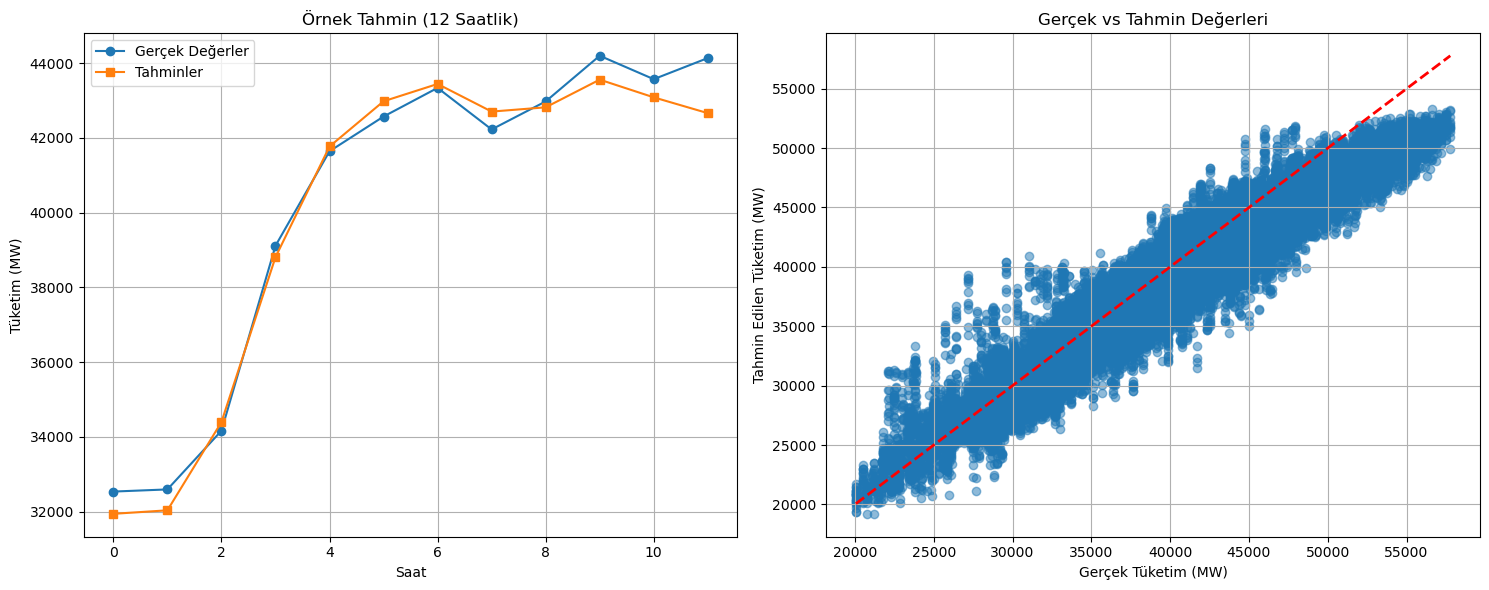

In [7]:
if __name__ == "__main__":
    df = load_data('csv_files/realtime_generation_data.csv', 
                   'csv_files/realtime_consumption_data.csv')
    
    df = create_features(df)
    
    (X_train, y_train, X_test, y_test), (scaler_X, scaler_y) = prepare_data_for_autoformer(df, feature_columns)
    
    model = create_model(input_size=len(feature_columns))
    
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    best_model = train_model(model, train_loader, test_loader)
    
    best_model.eval()
    predictions_list = []
    with torch.no_grad():
        for i in range(0, len(X_test), 32):
            batch_x = X_test[i:i+32]
            batch_pred = best_model(batch_x)
            predictions_list.append(batch_pred)

    predictions = torch.cat(predictions_list, dim=0)
    predictions = predictions.squeeze(-1).numpy()
    actuals = y_test.squeeze(-1).numpy()
    
    predictions = scaler_y.inverse_transform(predictions)
    actuals = scaler_y.inverse_transform(actuals)
    
    metrics = calculate_metrics(actuals.reshape(-1), predictions.reshape(-1))
    visualize_results(predictions, actuals)